In [68]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import scipy.misc 
%matplotlib inline
from scipy.misc import imresize
from six.moves import cPickle

savename = 'Motif_'
savedir = '/home/peter/Documents/'+savename


In [4]:
# load motif list from file
motiflist = 'motif.pickle' 
f = open(motiflist, 'rb')
motif_set = cPickle.load(f)
f.close()

In [5]:
def generate_pwm_model(filter_size, motif):
    motif_len = motif.shape[1]
    if filter_size > motif_len:
        offset = (filter_size - motif_len)
        pwm_model = np.hstack((motif, np.ones((4,offset))/4))
    elif filter_size < motif_len:
        pwm_model = motif[:,:filter_size]
    else:
        pwm_model = motif
    return pwm_model

def simulate_sequence(pwm_model, num_sim):
    N = pwm_model.shape[1]
    seq_data = []
    for k in xrange(num_sim):
        Z = np.random.uniform(0,1,N)
        cum_prob = pwm_model.cumsum(axis=0)
        sequence = np.zeros(pwm_model.shape)
        for i in xrange(N):
            index=[j for j in xrange(4) if Z[i] < cum_prob[j,i]][0]
            sequence[index,i] = 1 
        seq_data.append(sequence)
    return np.array(seq_data)

In [101]:
motif_set[1]

,0,1,2,3,4,5,6
A,0.017519,0.017519,0.111033,0.202325,0.017519,0.017519,0.040588
C,0.017519,0.017519,0.017519,0.114996,0.017519,0.017519,0.040588
G,0.101852,0.017519,0.115479,0.477455,0.190051,0.111710,0.040588
U,0.863110,0.947443,0.755968,0.205224,0.774911,0.853252,0.878235


In [161]:
filter_size = 8
motif = np.array(motif_set[0])[:,:]
num_sim = 50000

pwm_model = generate_pwm_model(filter_size, motif)
positive_data = simulate_sequence(pwm_model, num_sim)

null_motif = np.ones(motif.shape)/4
null_model = generate_pwm_model(filter_size, null_motif)
control_data = simulate_sequence(null_model, num_sim)
positive = np.zeros(num_sim)
control = np.zeros(num_sim)
for i in range(num_sim):
    positive[i] = np.sum(positive_data[i]*pwm_model)
    control[i] = np.sum(control_data[i]*pwm_model)

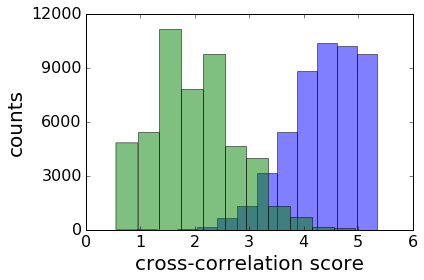

In [162]:
bins=12
fig = plt.figure()
N = plt.hist(positive,bins=bins, alpha = 0.5)
N2 = plt.hist(control, bins=bins, alpha = 0.5)
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.xlabel('cross-correlation score', fontsize=20)
plt.ylabel('counts', fontsize=20)
#plt.xticks([0.055, 0.07, 0.085])
plt.yticks([0, 3000, 6000, 9000, 12000])
outfile = savedir+ '_pwm_histogram.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  

<Container object of 3 artists>

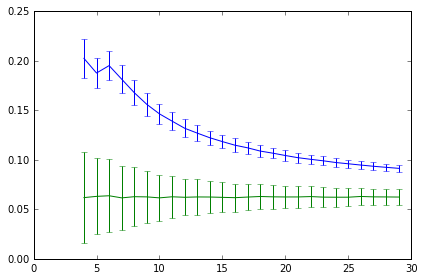

In [109]:
# vary filter size --> monitor background level and signal level for a given motif_size=5
motif = np.array(motif_set[2])[:,:]
num_sim = 1000
filter_range = range(4,30)

signal = []
signal_err = []
background = []
background_err = []
for filter_size in filter_range:

    pwm_model = generate_pwm_model(filter_size, motif)
    positive_data = simulate_sequence(pwm_model, num_sim)

    null_motif = np.ones(motif.shape)/4
    null_model = generate_pwm_model(filter_size, null_motif)
    control_data = simulate_sequence(null_model, num_sim)

    positive = np.zeros(num_sim)
    control = np.zeros(num_sim)
    for i in range(num_sim):
        positive[i] = np.mean(positive_data[i]*pwm_model)
        control[i] = np.mean(control_data[i]*pwm_model)
        
    signal.append(np.mean(positive))
    signal_err.append(np.std(positive))
    background.append(np.mean(control))
    background_err.append(np.std(control))
signal = np.array(signal)
signal_err = np.array(signal_err)
background = np.array(background)
background_err = np.array(background_err)

plt.figure()
plt.errorbar(filter_range, signal, signal_err)
plt.errorbar(filter_range, background, background_err)


In [142]:
motif.T

array([[ 0.08031797,  0.08031797,  0.75904609,  0.08031797],
       [ 0.82939504,  0.05686832,  0.05686832,  0.05686832],
       [ 0.12250438,  0.7205511 ,  0.12375305,  0.03319146],
       [ 0.00912272,  0.00912272,  0.87682875,  0.10492582],
       [ 0.76749869,  0.00912272,  0.21425589,  0.00912272],
       [ 0.23953031,  0.69371809,  0.0333758 ,  0.0333758 ],
       [ 0.45131037,  0.28509158,  0.18261763,  0.08098042],
       [ 0.4460034 ,  0.05667252,  0.05667252,  0.44065157],
       [ 0.00901703,  0.00901703,  0.00901703,  0.97294891],
       [ 0.97294891,  0.00901703,  0.00901703,  0.00901703],
       [ 0.00901703,  0.97294891,  0.00901703,  0.00901703],
       [ 0.5828654 ,  0.00901703,  0.00901703,  0.39910054],
       [ 0.00901703,  0.00901703,  0.00901703,  0.97294891],
       [ 0.1044603 ,  0.1044603 ,  0.19473218,  0.59634722]])

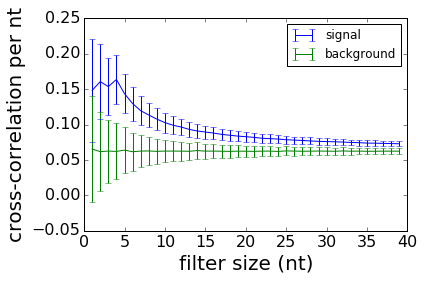

In [203]:
cutoff=4
motif1 = np.array(motif_set[0])
motif2 = np.array(motif_set[2])
motif3 = np.array(motif_set[3])

motif = np.hstack([motif1,motif2, motif3])
motif = motif[:,:cutoff]

num_sim = 1000
filter_range = range(1,40)

signal = []
signal_err = []
background = []
background_err = []
for filter_size in filter_range:

    pwm_model = generate_pwm_model(filter_size, motif)
    positive_data = simulate_sequence(pwm_model, num_sim)

    null_motif = np.ones(motif.shape)/4
    null_model = generate_pwm_model(filter_size, null_motif)
    control_data = simulate_sequence(null_model, num_sim)

    positive = np.zeros(num_sim)
    control = np.zeros(num_sim)
    for i in range(num_sim):
        positive[i] = np.mean(positive_data[i]*pwm_model)
        control[i] = np.mean(control_data[i]*pwm_model)

    signal.append(np.mean(positive))
    signal_err.append(np.std(positive))
    background.append(np.mean(control))
    background_err.append(np.std(control))
signal = np.array(signal)
signal_err = np.array(signal_err)
background = np.array(background)
background_err = np.array(background_err)


fig = plt.figure()
plt.errorbar(filter_range, signal, signal_err)
plt.errorbar(filter_range, background, background_err)
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.ylabel('cross-correlation per nt', fontsize=20)
plt.xlabel('filter size (nt)', fontsize=20)
plt.legend(['signal','background'])
outfile = savedir+ '_pwm_filtersize=4.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  


In [186]:
# vary filter size --> monitor background level and signal level for a given motif_size=5

fig = plt.figure()
SNR = []
for cutoff in range(4,18,2):
    motif1 = np.array(motif_set[0])
    motif2 = np.array(motif_set[2])
    motif3 = np.array(motif_set[3])
    
    motif = np.hstack([motif1,motif2, motif3])
    motif = motif[:,:cutoff]
    
    num_sim = 1000
    filter_range = range(cutoff,cutoff+30)

    signal = []
    signal_err = []
    background = []
    background_err = []
    for filter_size in filter_range:

        pwm_model = generate_pwm_model(filter_size, motif)
        positive_data = simulate_sequence(pwm_model, num_sim)

        null_motif = np.ones(motif.shape)/4
        null_model = generate_pwm_model(filter_size, null_motif)
        control_data = simulate_sequence(null_model, num_sim)

        positive = np.zeros(num_sim)
        control = np.zeros(num_sim)
        for i in range(num_sim):
            positive[i] = np.sum(positive_data[i]*pwm_model)
            control[i] = np.sum(control_data[i]*pwm_model)

        signal.append(np.mean(positive))
        signal_err.append(np.std(positive))
        background.append(np.mean(control))
        background_err.append(np.std(control))
    signal = np.array(signal)
    signal_err = np.array(signal_err)
    background = np.array(background)
    background_err = np.array(background_err)

    #plt.figure()
    #plt.errorbar(filter_range, signal, signal_err)
    #plt.errorbar(filter_range, background, background_err)

    SNR.append(signal/background)

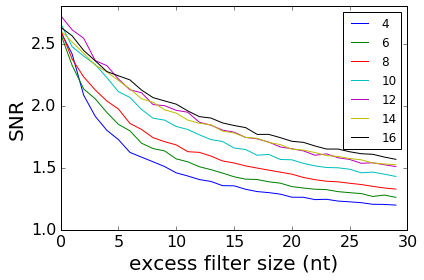

In [204]:
SNR = np.array(SNR)

fig = plt.figure()
plt.plot(SNR.T)

ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.ylabel('SNR', fontsize=20)
plt.xlabel('excess filter size (nt)', fontsize=20)
plt.legend(legend)
outfile = savedir+ '_pwm_vary_filtersize.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  



<Container object of 3 artists>

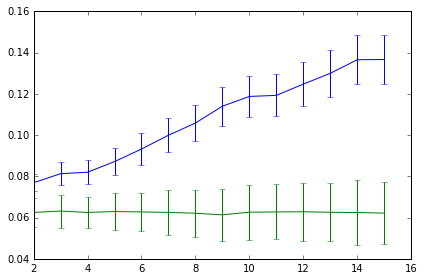

In [182]:
# for a fixed filter size, vary motif size

motif_template = np.array(motif_set[1])
motif_template = np.hstack([motif_template,motif_template])
num_sim = 1000
filter_size = 20
size_range = range(2,16)

signal = []
signal_err = []
background = []
background_err = []
for motif_size in size_range:
    motif = motif_template[:,:motif_size]
    pwm_model = generate_pwm_model(filter_size, motif)
    positive_data = simulate_sequence(pwm_model, num_sim)

    null_motif = np.ones(motif.shape)/4
    null_model = generate_pwm_model(filter_size, null_motif)
    control_data = simulate_sequence(null_model, num_sim)

    positive = np.zeros(num_sim)
    control = np.zeros(num_sim)
    for i in range(num_sim):
        positive[i] = np.mean(positive_data[i]*pwm_model)
        control[i] = np.mean(control_data[i]*pwm_model)
        
    signal.append(np.mean(positive))
    signal_err.append(np.std(positive))
    background.append(np.mean(control))
    background_err.append(np.std(control))
signal = np.array(signal)
signal_err = np.array(signal_err)
background = np.array(background)
background_err = np.array(background_err)

plt.figure()
plt.errorbar(size_range, signal, signal_err)
plt.errorbar(size_range, background, background_err)


In [181]:
motif.shape

(4,)

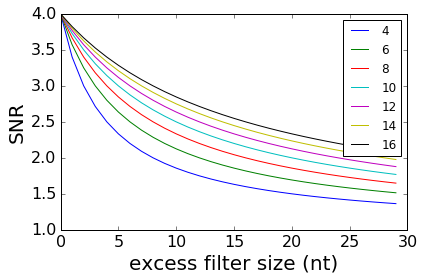

In [179]:

fig = plt.figure()
legend = []
for M in range(4, 18,2):
    E = np.array(range(0,30)).astype(float)

    SNR = (4*M+E)/(M+E)
    plt.plot(SNR)
    legend.append(str(M))
    
ax = plt.gca()
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.ylabel('SNR', fontsize=20)
plt.xlabel('excess filter size (nt)', fontsize=20)
plt.legend(legend)
outfile = savedir+ '_pwm_theory_vary_filtersize.pdf'
fig.savefig(outfile, format='pdf', dpi=1000)  
